### DATA
https://datasciencecapstone.org/competitions/9/predicting-chronic-hunger/page/29/
#### Simple EDA & Data cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fancyimpute import KNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
train_y = pd.read_csv('D:/Download/train_labels.csv')
train_x = pd.read_csv('D:/Download/train_values_6tLXv3T.csv')
test = pd.read_csv('D:/Download/test_values_K7FqC54.csv')
print(train_x.shape,train_y.shape,test.shape)
# train_x.columns
print(train_y.prevalence_of_undernourishment.describe())

C:\Users\Mozzie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(1401, 46) (1401, 2) (616, 46)
count    1401.000000
mean       15.510697
std        11.610440
min         2.493428
25%         5.710856
50%        12.118656
75%        22.447492
max        59.089781
Name: prevalence_of_undernourishment, dtype: float64


In [2]:
#To Answer Data Exploration Questions
# df =train_x
# df['target'] = train_y.prevalence_of_undernourishment
# x = df.groupby('year')
# x.median().target
# x.mean().target


In [3]:
#print correlation between y and columns
imp_num=[]
imp=[]
for i in train_x.columns[3:-1]:
    tmp = train_y.prevalence_of_undernourishment.corr(train_x[i])
    print(i,':',tmp)
    imp += [abs(tmp)]
    if abs(tmp)>0.5:
        imp_num += [i]
#         print(i,':',tmp)
# plt.plot(df_num.columns,imp)
print(imp_num)

agricultural_land_area : 0.006627019407177683
percentage_of_arable_land_equipped_for_irrigation : -0.13804832873565062
cereal_yield : -0.2494697494931741
droughts_floods_extreme_temps : 0.23699225101399282
forest_area : -0.003169208649612557
total_land_area : -0.002453393428038266
fertility_rate : 0.49710752762865207
life_expectancy : -0.4762636882424877
rural_population : 0.054463319809451495
total_population : 0.025694981997350843
urban_population : -0.0337592314931599
population_growth : 0.2552048982710409
avg_value_of_food_production : -0.38971999758215176
cereal_import_dependency_ratio : 0.04633042477600196
food_imports_as_share_of_merch_exports : 0.1817559386257268
gross_domestic_product_per_capita_ppp : -0.33551291971331765
imports_of_goods_and_services : -0.0015793586431821613
inequality_index : 0.18479907925171132
net_oda_received_percent_gni : 0.37788788969121
net_oda_received_per_capita : 0.021530719418286673
tax_revenue_share_gdp : -0.18108905400981284
trade_in_services : 0

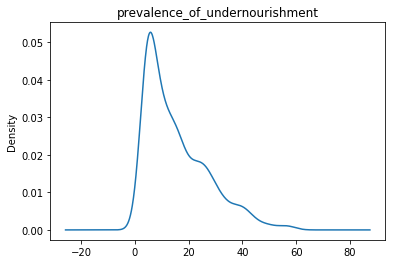

In [4]:
#target distribution
train_y.prevalence_of_undernourishment.plot(kind='density',title='prevalence_of_undernourishment')

Catogory: Index(['country_code', 'year'], dtype='object')


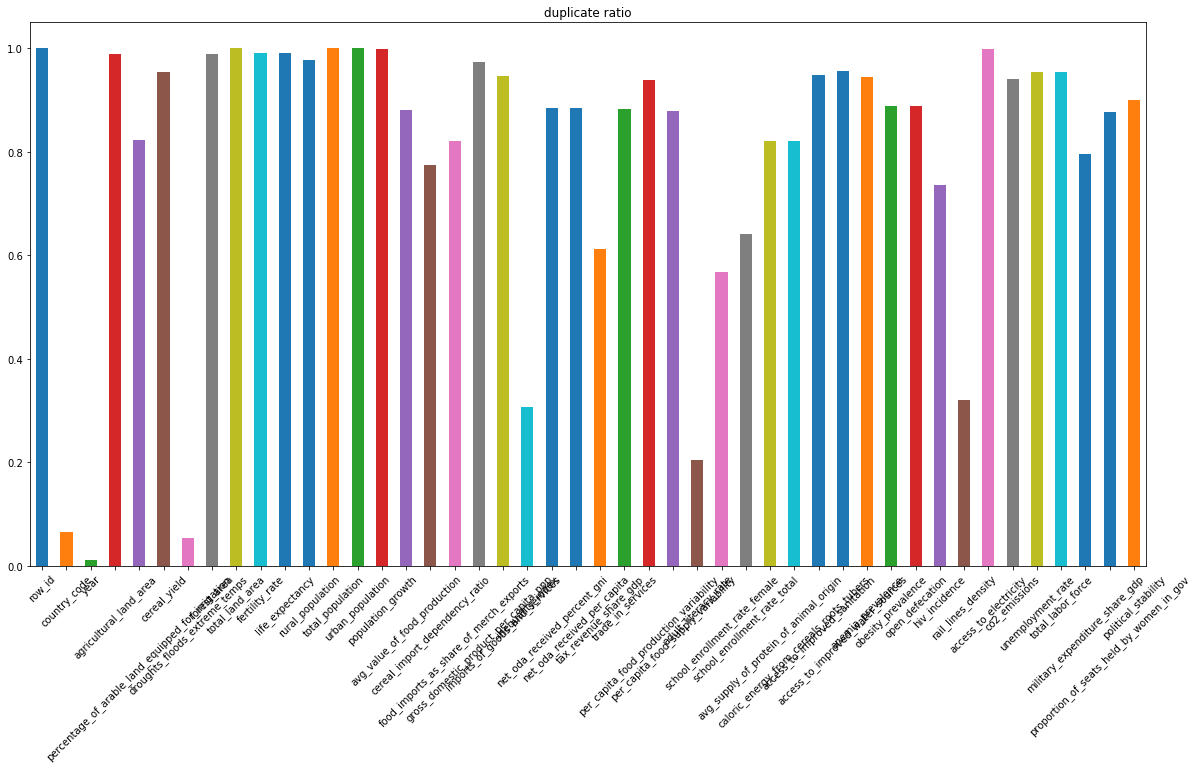

In [5]:
# duplicate ratio
plt.figure(figsize=(20,10))
(train_x.apply(lambda x:x.unique().shape[0],axis=0)/train_x.shape[0]).plot(kind='bar',rot=45,title='duplicate ratio')
print('Catogory:',train_x.columns[1:3])
#check whether id has duplicate rows
assert len(train_x.row_id.unique())-train_x.shape[0]==0

na.ratio>0.4 :
droughts_floods_extreme_temps    0.946467
inequality_index                 0.693790
adult_literacy_rate              0.796574
school_enrollment_rate_female    0.432548
rail_lines_density               0.673804
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


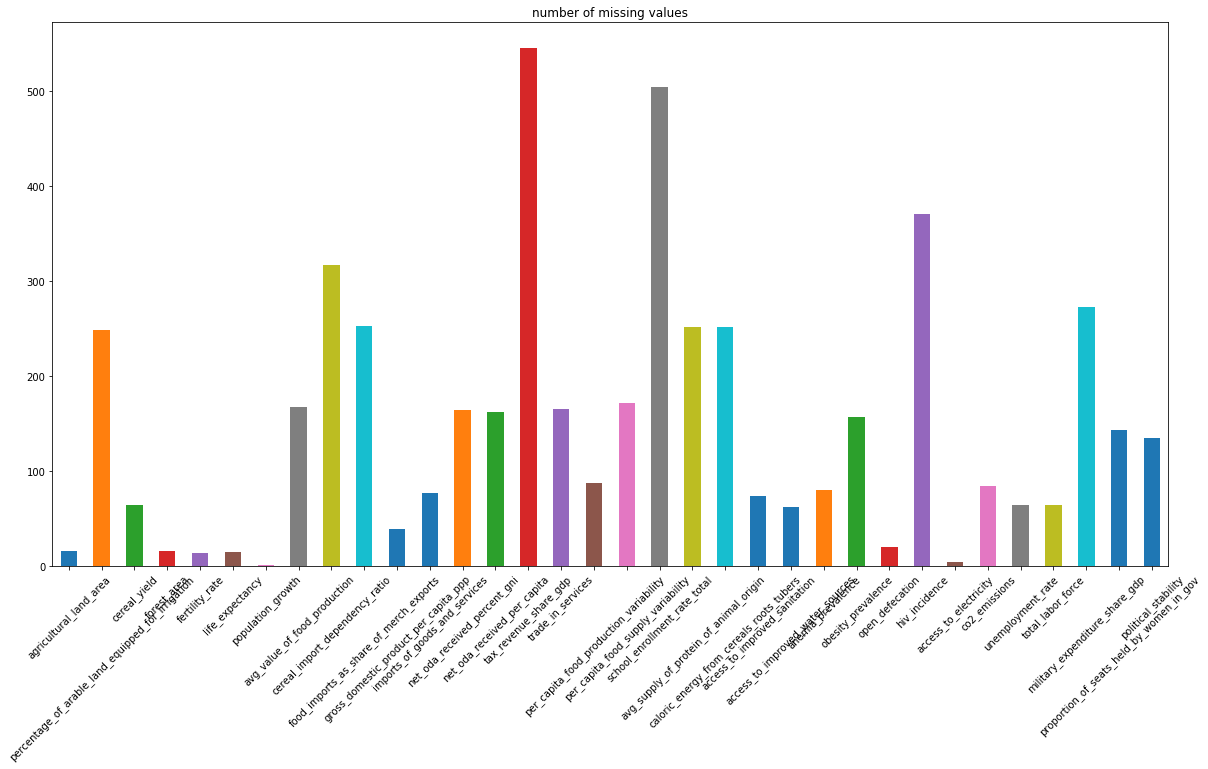

In [6]:
#remove na.ratio>0.4 columns
na_ratio = train_x.isna().sum()/train_x.shape[0]
tmp = na_ratio[na_ratio>0.4]
print('na.ratio>0.4 :',tmp,sep='\n')
droped_columns=tmp.index
train_x = train_x.drop(columns=droped_columns)
tmp = train_x.isna().sum()/train_x.shape[0]
tmpp = tmp[tmp>0]
plt.figure(figsize=(20,10))
print(train_x[tmpp.index].isnull().sum().plot(kind='bar',rot=45,title='number of missing values'))

AxesSubplot(0.125,0.125;0.775x0.755)


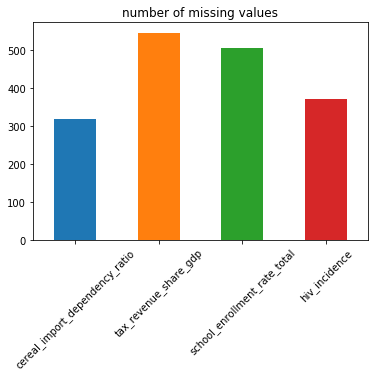

In [7]:
#rest high na_ratio columns
tmpp = tmp[tmp>0.2]
print(train_x[tmpp.index].isnull().sum().plot(kind='bar',rot=45,title='number of missing values'))

In [8]:
#fillna with KNN
train_x2 = KNN(k=5).fit_transform(train_x.iloc[:,3:])
train_x_df = pd.DataFrame(data=train_x2,index=range(1401),columns=train_x.columns[3:])
train_x_df['year'] = train_x.year
train_x = train_x_df
assert train_x.shape[1]==39
assert train_x.isna().any().sum()==0

Imputing row 1/1401 with 3 missing, elapsed time: 0.506
Imputing row 101/1401 with 0 missing, elapsed time: 0.506
Imputing row 201/1401 with 5 missing, elapsed time: 0.506
Imputing row 301/1401 with 0 missing, elapsed time: 0.521
Imputing row 401/1401 with 0 missing, elapsed time: 0.521
Imputing row 501/1401 with 1 missing, elapsed time: 0.521
Imputing row 601/1401 with 1 missing, elapsed time: 0.537
Imputing row 701/1401 with 2 missing, elapsed time: 0.537
Imputing row 801/1401 with 0 missing, elapsed time: 0.537
Imputing row 901/1401 with 1 missing, elapsed time: 0.552
Imputing row 1001/1401 with 4 missing, elapsed time: 0.552
Imputing row 1101/1401 with 2 missing, elapsed time: 0.552
Imputing row 1201/1401 with 2 missing, elapsed time: 0.568
Imputing row 1301/1401 with 18 missing, elapsed time: 0.568
Imputing row 1401/1401 with 0 missing, elapsed time: 0.568


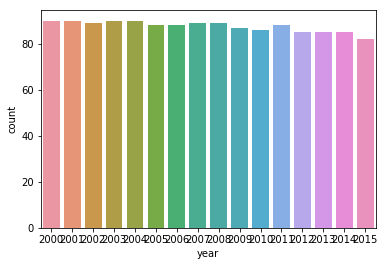

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


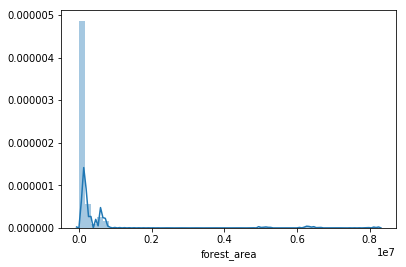

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


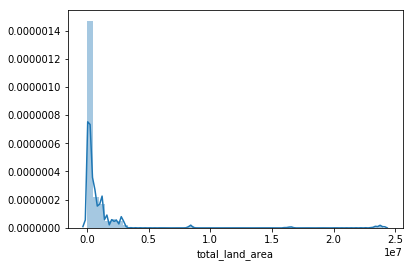

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


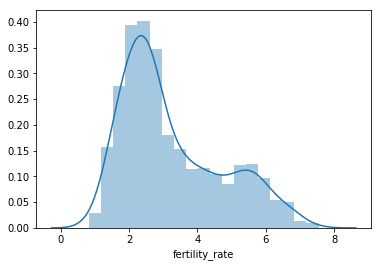

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


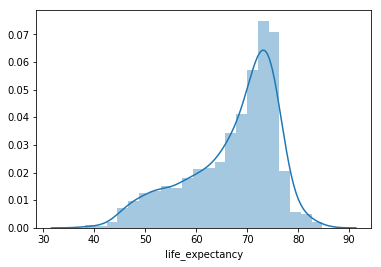

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


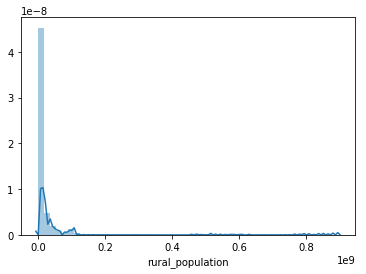

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


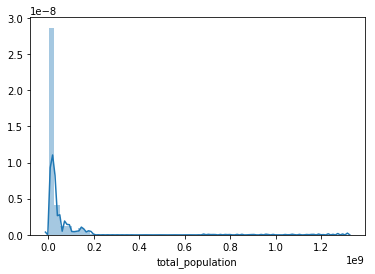

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


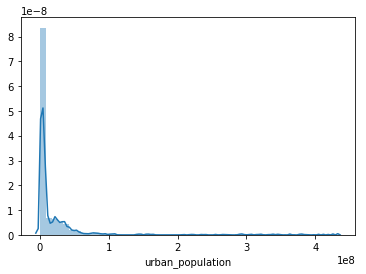

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


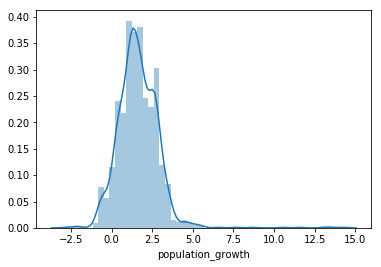

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


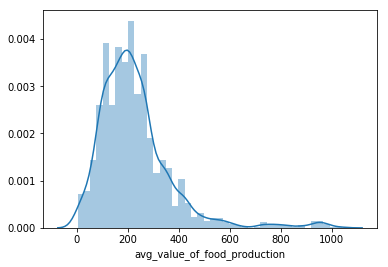

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


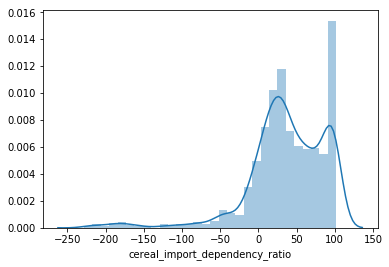

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


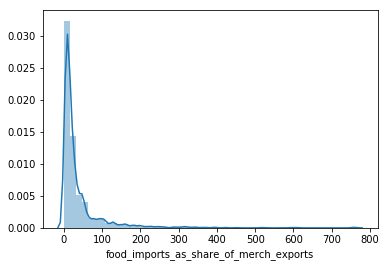

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


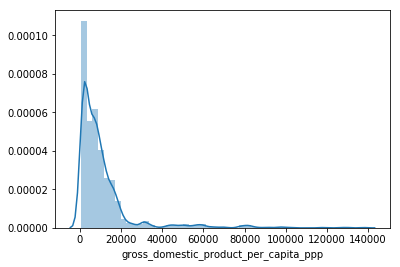

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


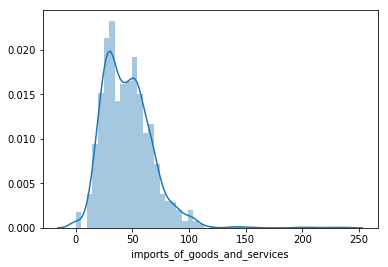

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


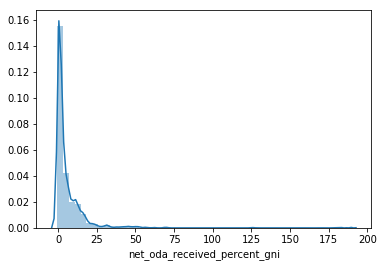

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


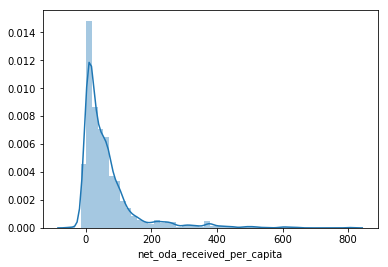

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


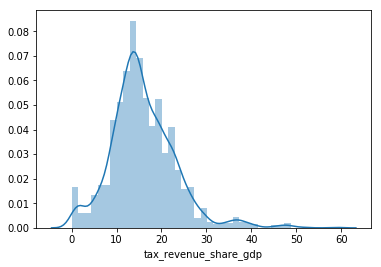

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


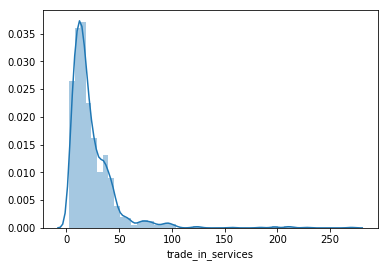

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


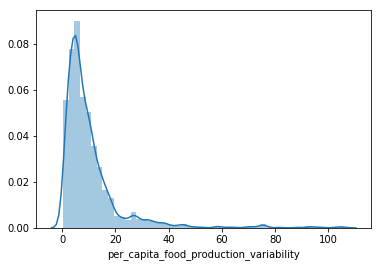

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


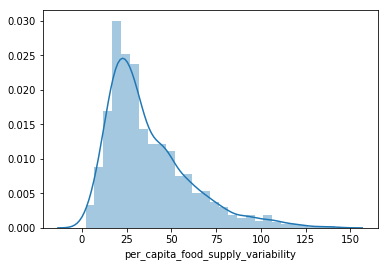

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


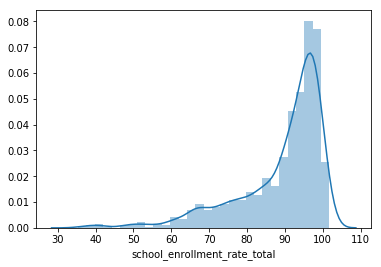

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


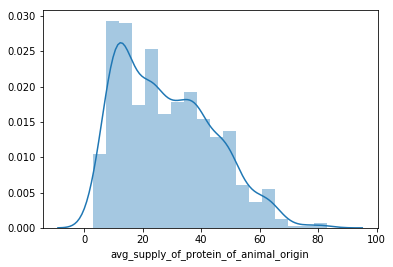

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


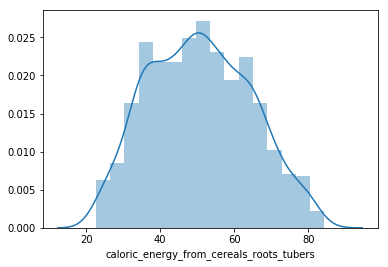

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


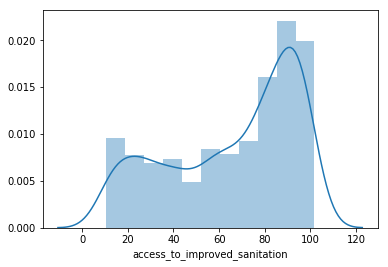

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


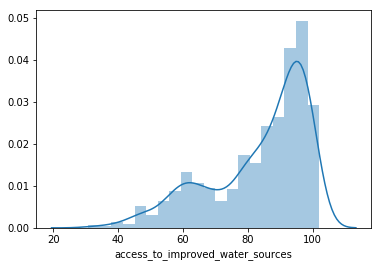

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


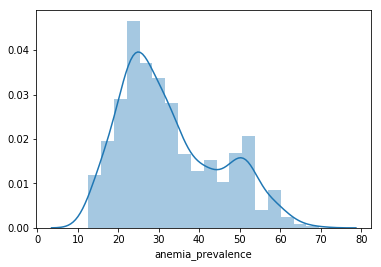

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


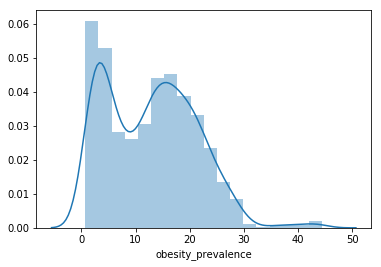

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


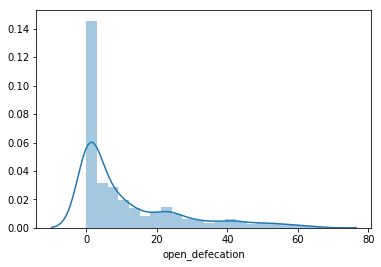

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


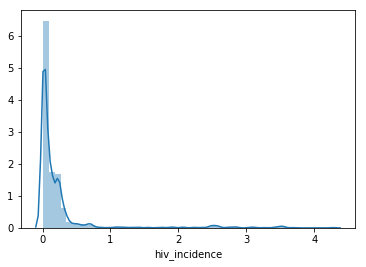

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


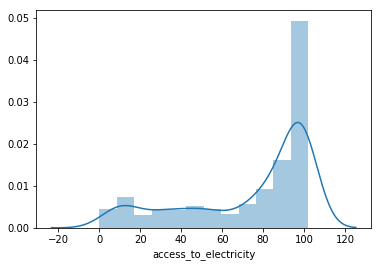

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


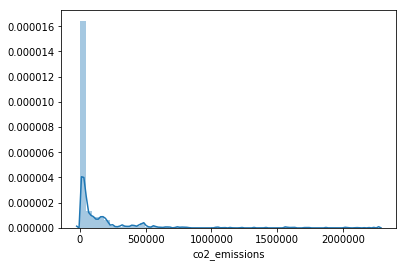

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


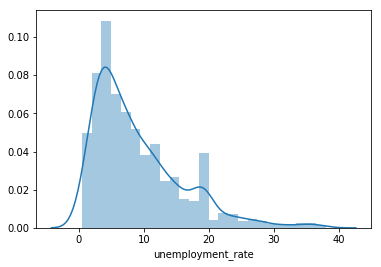

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


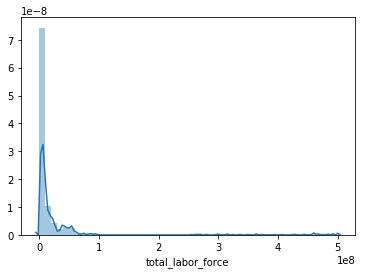

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


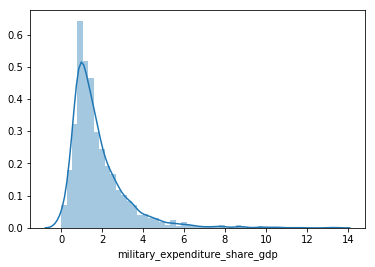

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


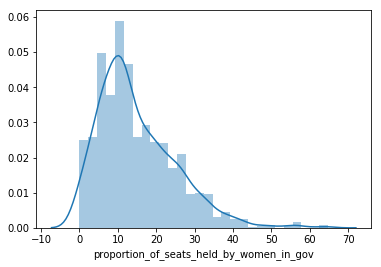

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


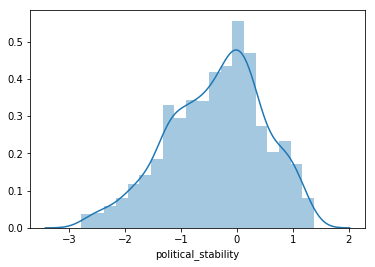

In [9]:
#print columns distribution
sns.countplot(x='year', data=train_x)
plt.show()
for i in train_x.columns[3:-1]:
    sns.distplot(train_x[i])
    plt.show()

In [10]:
#replace outliers
for col in train_x.columns[3:-1]:
    scaler = StandardScaler()
    scaler.fit(train_x[[col]])
    ss = scaler.transform(train_x[[col]])
    maxv = ss.mean()+3*ss.std()
    minv = ss.mean()-3*ss.std()
    for i in range(len(ss)):
        if ss[i]<minv:
            ss[i] = minv
        if ss[i]>maxv:
            ss[i] = maxv
    train_x[col] = scaler.inverse_transform(ss)

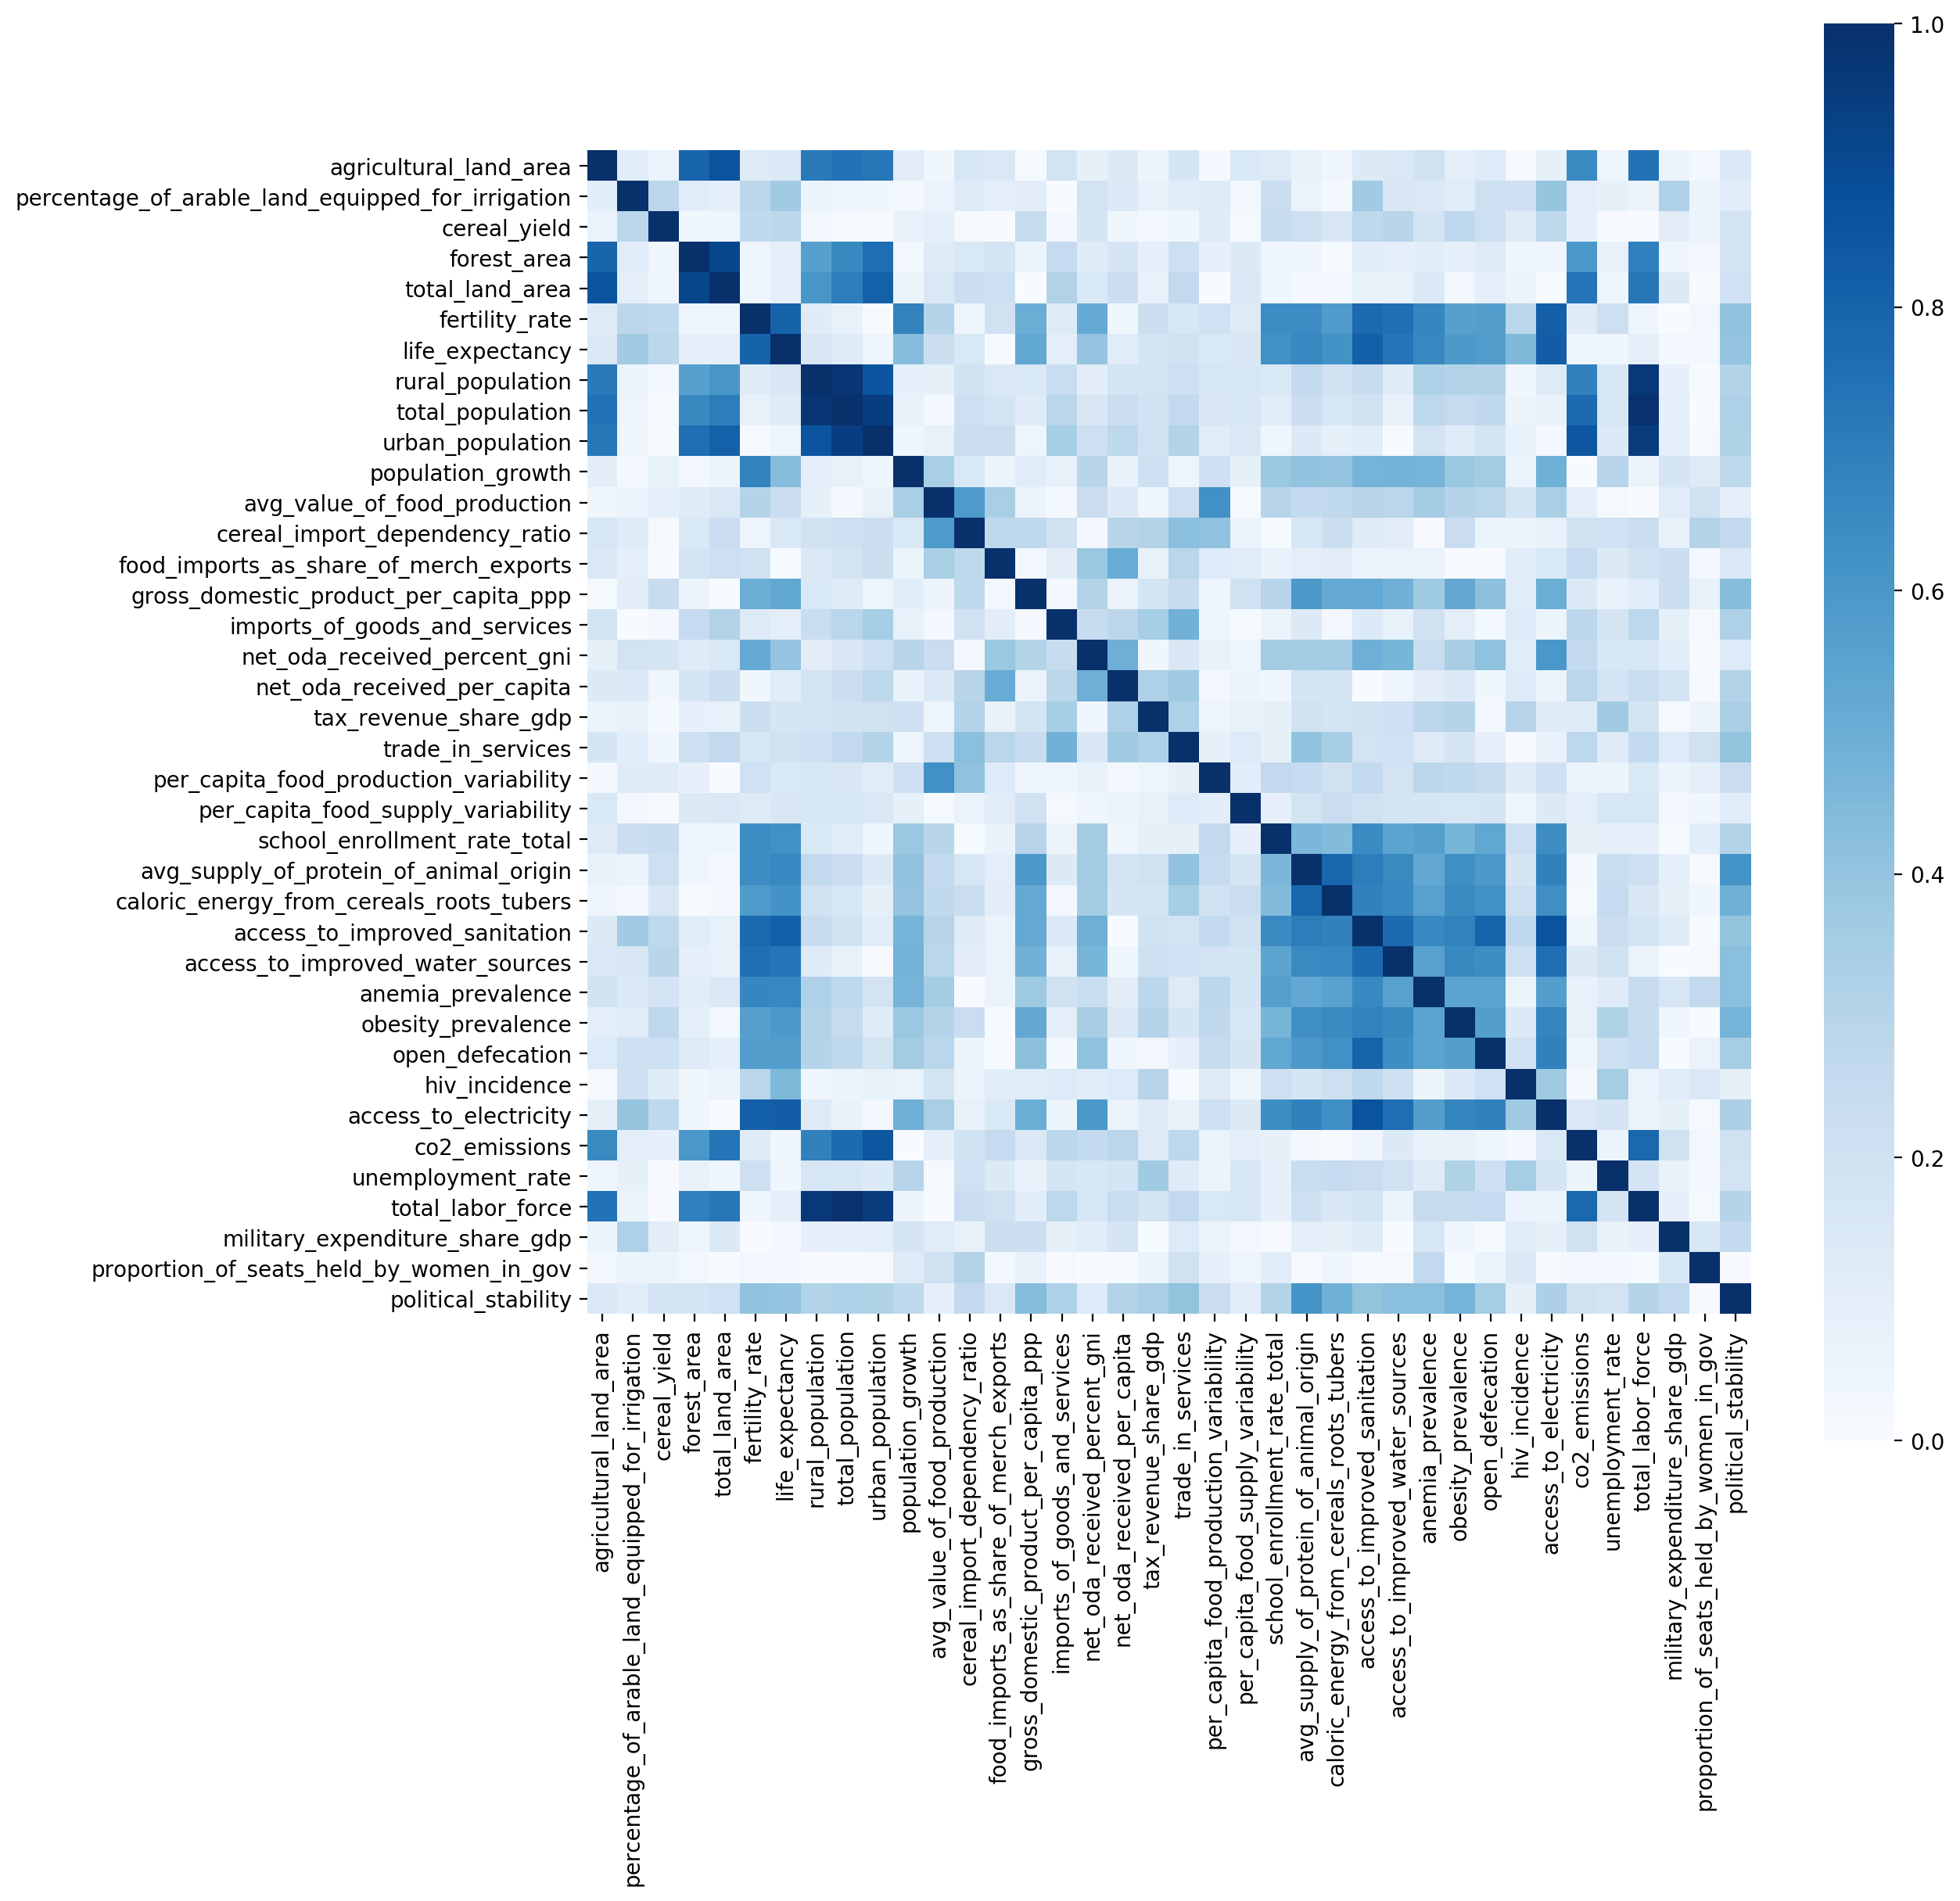

In [11]:
#print correlation table
plt.figure(figsize=(12,12),dpi=200)
sns.heatmap( abs(train_x.drop(columns=['year']).corr()),cmap="Blues",
             vmin=0,
             vmax=1,
             square=True,
             annot=False)
plt.show()

In [12]:
#list high correlation column pairs
tmp = abs(train_x.drop(columns=['year']).corr())
tmpp = tmp[tmp!=1]
pair=[]
prePCA=[]
for i in range(tmpp.shape[0]):
    for j in range(tmpp.shape[0]):
        if tmpp.iloc[i,j]>0.7:
            pair += [tmpp.columns[i]+tmpp.columns[j]]
            if tmpp.columns[j]+tmpp.columns[i] not in pair:
                print(tmpp.columns[i],'--------',tmpp.columns[j])
                prePCA+=[(tmpp.columns[i],tmpp.columns[j])]


agricultural_land_area -------- forest_area
agricultural_land_area -------- total_land_area
agricultural_land_area -------- rural_population
agricultural_land_area -------- total_population
agricultural_land_area -------- urban_population
agricultural_land_area -------- total_labor_force
forest_area -------- total_land_area
forest_area -------- urban_population
total_land_area -------- total_population
total_land_area -------- urban_population
total_land_area -------- co2_emissions
total_land_area -------- total_labor_force
fertility_rate -------- life_expectancy
fertility_rate -------- access_to_improved_sanitation
fertility_rate -------- access_to_improved_water_sources
fertility_rate -------- access_to_electricity
life_expectancy -------- access_to_improved_sanitation
life_expectancy -------- access_to_improved_water_sources
life_expectancy -------- access_to_electricity
rural_population -------- total_population
rural_population -------- urban_population
rural_population -------- t

In [13]:
#list columns might have Multi-Collinearity problem
flattened_list = set([y for x in prePCA for y in x])
print(flattened_list)

{'co2_emissions', 'life_expectancy', 'access_to_improved_sanitation', 'forest_area', 'rural_population', 'urban_population', 'access_to_improved_water_sources', 'avg_supply_of_protein_of_animal_origin', 'open_defecation', 'total_land_area', 'total_labor_force', 'total_population', 'caloric_energy_from_cereals_roots_tubers', 'fertility_rate', 'agricultural_land_area', 'access_to_electricity'}


In [14]:
#try to fix Multi-Collinearity problem

train_x['rural_population'] = train_x.rural_population/train_x.total_population
train_x['urban_population'] = train_x.urban_population/train_x.total_population
train_x['agricultural_land_area'] = train_x.agricultural_land_area/train_x.total_land_area
train_x['forest_area'] = train_x.forest_area/train_x.total_land_area
train_x.rename(columns={'rural_population':'rural_population_ratio',
               'urban_population':'urban_population_ratio',
               'agricultural_land_area':'agricultural_land_area_ratio',
               'forest_area':'forest_area_ratio'},inplace=True)

def Polymerization(cols,new_name,data):
    pca = PCA(n_components=1)
    new_col = pca.fit_transform(data[cols])
    data.drop(columns=cols,inplace=True)
    data[new_name]=new_col
    return data

health_food = ['avg_supply_of_protein_of_animal_origin','caloric_energy_from_cereals_roots_tubers']
health_facility = ['life_expectancy','access_to_improved_sanitation','access_to_improved_water_sources','access_to_electricity','fertility_rate']
Polymerization(health_food,'health_food',train_x)
Polymerization(health_facility,'health_facility',train_x)
print(train_x.shape)

(1401, 34)


In [15]:
#one-hot encoding catogory column
train_x = pd.get_dummies(data=train_x,columns=['year'])
print(train_x.shape)

(1401, 49)


In [16]:
def prepare_test(test):
    test.drop_duplicates(subset=['row_id'],inplace=True)
    test.drop(columns=['row_id','country_code'],inplace=True)
    test.drop(columns=droped_columns,inplace=True)
    knn = KNN(k=5).fit_transform(test.drop(columns=['year']))
    test2 = pd.DataFrame(data=knn,index=range(test.shape[0]),columns=test.drop(columns=['year']).columns)    
    test2['year'] = test.year
    assert test2.shape[1]==39
    assert test2.isna().any().sum()==0
    test2['rural_population'] = test2.rural_population/test2.total_population
    test2['urban_population'] = test2.urban_population/test2.total_population
    test2['agricultural_land_area'] = test2.agricultural_land_area/test2.total_land_area
    test2['forest_area'] = test2.forest_area/test2.total_land_area
    test2.rename(columns={'rural_population':'rural_population_ratio',
               'urban_population':'urban_population_ratio',
               'agricultural_land_area':'agricultural_land_area_ratio',
               'forest_area':'forest_area_ratio'},inplace=True)
    assert test2.isna().any().sum()==0
    Polymerization(health_food,'health_food',test2)
    Polymerization(health_facility,'health_facility',test2)
    test2 = pd.get_dummies(data=test2,columns=['year'])
    return test2
test = prepare_test(test)

Imputing row 1/616 with 3 missing, elapsed time: 0.116
Imputing row 101/616 with 1 missing, elapsed time: 0.121
Imputing row 201/616 with 0 missing, elapsed time: 0.125
Imputing row 301/616 with 1 missing, elapsed time: 0.129
Imputing row 401/616 with 12 missing, elapsed time: 0.133
Imputing row 501/616 with 1 missing, elapsed time: 0.136
Imputing row 601/616 with 10 missing, elapsed time: 0.139


In [17]:
#Standardlization
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test = scaler.transform(test)
train_x.shape,train_y.shape,test.shape

((1401, 49), (1401, 2), (616, 49))

In [18]:
#feature selection
clf = LassoCV(cv=10)
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(train_x, train_y.iloc[:,1])
tmp = sfm.transform(train_x)
tmp2 = sfm.transform(test)
tmp.shape,tmp2.shape
# assert tmp.shape[1]==tmp2.transform(train_x).shape[1]

((1401, 28), (616, 28))

In [19]:
#Fitting RandomForest regressor
regr = RandomForestRegressor(n_estimators=465,oob_score=True,n_jobs=-1)
regr.fit(train_x, train_y.iloc[:,1])
pred_y = regr.predict(test)
print(pred_y)

[ 4.78825679  6.40536906 11.65210905 25.02782966 19.1606711  25.75196782
 25.42841519 23.50806628 41.17442234 36.18555183 14.02581172 17.26961323
  9.95987183  4.51079734 28.18921502 22.1632535  32.77899441 15.42153006
 13.69812225 17.41910199 18.43842972 23.54543879  5.05570667  4.57874209
 10.4139729  21.78524158 17.60771034 11.43054809  5.85745152  4.84272438
 15.42218184 12.02154441  5.44597648 14.1069694  12.76431857 32.08646834
 31.78633742 10.71962983  6.53042429 23.84043803 23.12289059 20.3938767
 14.87485119 12.4874607   6.51794357 24.27797662 27.59376453 10.47718393
 39.28640175 20.2942047  14.97990957 17.92995307  7.29648385 14.82498922
 28.82683693  5.17508697  8.98251087  8.81181259 29.45861358 14.64255738
 17.76715081 38.27302177 25.18468631 27.21230387 17.91897467 17.44623789
  7.82697506  7.9616422   8.36921516 26.95438088 14.60802755 26.8791376
  6.42587881 13.70563427 28.74253435 13.9879242  40.3212921  17.35797887
 13.93762525 11.75859992 20.20323397 24.04775069  9.7

In [20]:
#Fitting XGB regressor 
# xgbm = xgb.XGBRegressor(n_estimators=2500,learning_rate=0.001,max_depth=9999999,min_child_weight=1,n_jobs=-1)
# print(xgbm)
# xgbm.fit(train_x,train_y.iloc[:,1])
# pred_y2 = xgbm.predict(test)
# print(pred_y2)

In [21]:
#output
# summit=pd.DataFrame()
# summit['row_id']=range(test.shape[0])
# summit['prevalence_of_undernourishment']=pred_y
# summit.to_csv('D:/summit.csv',index=False)

In [22]:
##gridsearch 10fold
# rf = RandomForestRegressor(n_estimators=150,oob_score=True)
# param_test1 = {'n_estimators':range(270,500,5)}
# gsearch1 = GridSearchCV(rf,param_test1,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
# gsearch1.fit(train_x,train_y.iloc[:,1])
# print(gsearch1.best_params_)
# {'max_depth': 22, 'n_estimators': 275}
#{'n_estimators':range(270,500,5)} {'n_estimators': 465}